In [1]:
# -------------------------------------------------------------------------------------------------------------------------------
# 프로젝트 : 인물과 동물 사진을 만들어보자
# -------------------------------------------------------------------------------------------------------------------------------

원본 이미지 크기 : (544, 989, 3)
배경 이미지 크기 : (837, 1260, 3)
예측된 분할 마스크 크기 : (520, 520)
예측된 클래스 레이블 : 15
원본 이미지 크기로 변환된 예측된 분할 마스크 크기 : (544, 989)
원본 이미지 크기의 변환된 배경 이미지 크기 : (544, 989, 3)
예측된 컬러 마스크 크기 (544, 989, 3)


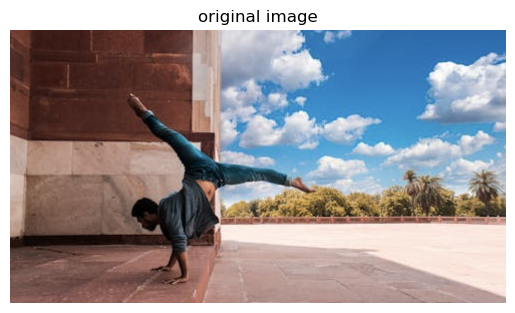

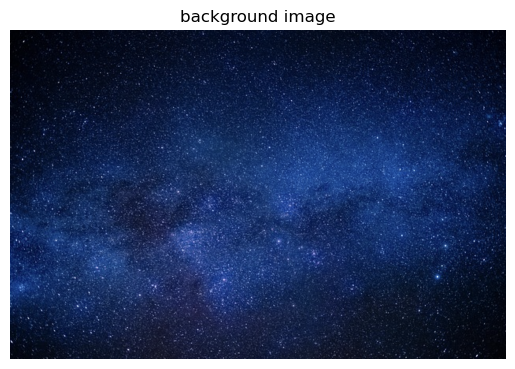

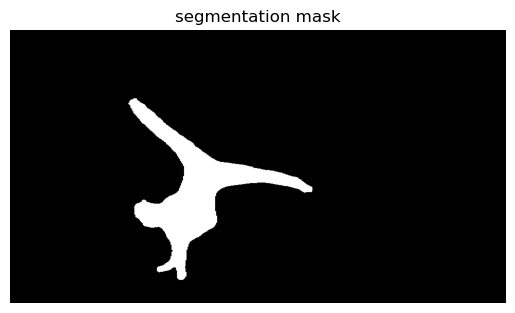

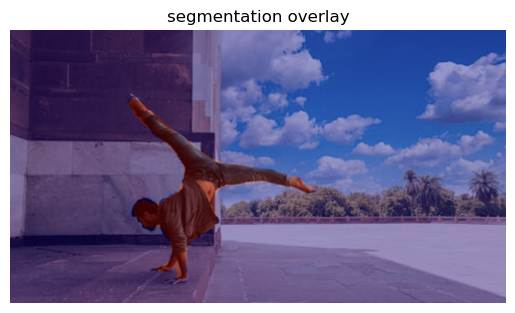

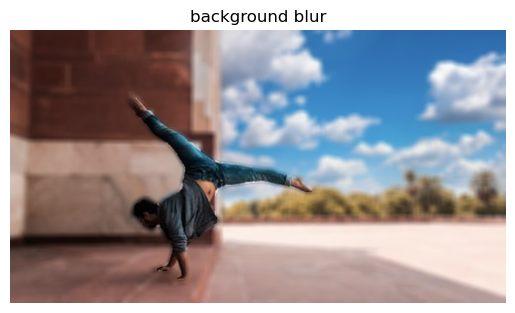

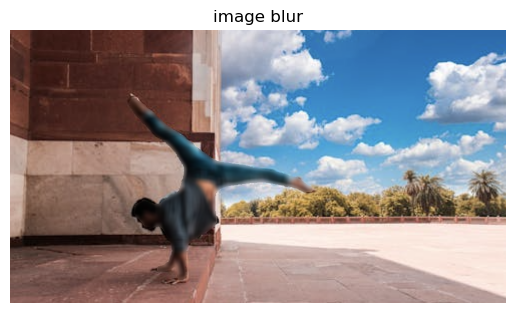

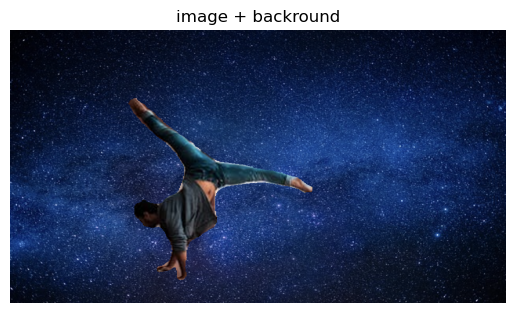

In [2]:
# -------------------------------------------------------------------------------------------------------------------------------
# 필수 라이브러리 
# -------------------------------------------------------------------------------------------------------------------------------
import os
import cv2 # 이미지 처리를 위한 OpenCV 라이브러리
import numpy as np
import torch
from torchvision import transforms # 이미지 전처리를 위한 transforms 라이브러리
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights # DeepLab v3 모델 설치
import matplotlib.pyplot as plt
# -------------------------------------------------------------------------------------------------------------------------------
# 이미지 경로 설정
# -------------------------------------------------------------------------------------------------------------------------------
home_dir = os.getenv('HOME')
# 분할을 원하는 이미지 경로
img_path = os.path.join(home_dir, "work/human_segmentation/images/human.png")
# 배경으로 사용할 이미지 경로
bg_img_path = os.path.join(home_dir, "work/human_segmentation/images/space.png")
img_orig = cv2.imread(img_path)
bg_img = cv2.imread(bg_img_path)
# OpenCV는 이미지를 BGR 형식으로 받기 때문에 RGB 형식으로 변환
img_orig_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
bg_img_rgb = cv2.cvtColor(bg_img, cv2.COLOR_BGR2RGB)
print(f"원본 이미지 크기 : {img_orig.shape}")
print(f"배경 이미지 크기 : {bg_img.shape}")
# -------------------------------------------------------------------------------------------------------------------------------
# 이미지 전처리
# -------------------------------------------------------------------------------------------------------------------------------
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize((520, 520)), 
                                transforms.ToTensor(),])
# -------------------------------------------------------------------------------------------------------------------------------
# 이미지 분할을 위한 DeepLab v3 (ResNet-101) 모델 불러오기 
# -------------------------------------------------------------------------------------------------------------------------------
weights = DeepLabV3_ResNet101_Weights.DEFAULT  
model = deeplabv3_resnet101(weights=weights).eval()
# DeepLab v3는 Pascal VOC에 대해 학습되었으며, 아래 클래스들만 분할 가능
# 클래스이름 : 인덱스 번호
# background      : 0     | aeroplane     : 1     | bicycle       : 2
# bird            : 3     | boat          : 4     | bottle        : 5
# bus             : 6     | car           : 7     | cat           : 8
# chair           : 9     | cow           : 10    | diningtable   : 11
# dog             : 12    | horse         : 13    | motorbike     : 14
# person          : 15    | pottedplant   : 16    | sheep         : 17
# sofa            : 18    | train         : 19    | tv            : 20
# 원하는 이미지를 선택할 때 위의 클래스에 속하는 이미지로 선택
# -------------------------------------------------------------------------------------------------------------------------------
# 이미지에 미니 배치 차원 추가
# -------------------------------------------------------------------------------------------------------------------------------
tensor = transform(img_orig_rgb).unsqueeze(0)
# -------------------------------------------------------------------------------------------------------------------------------
# 원하는 이미지 분할을 위한 추론
# -------------------------------------------------------------------------------------------------------------------------------
with torch.no_grad():
    output = model(tensor)["out"][0]
    predictions = output.argmax(0).byte().cpu().numpy()
# -------------------------------------------------------------------------------------------------------------------------------
# 예측된 클래스 레이블을 확인
# -------------------------------------------------------------------------------------------------------------------------------
predictions_class_id = np.unique(predictions)[-1]
print(f"예측된 분할 마스크 크기 : {predictions.shape}")
print(f"예측된 클래스 레이블 : {predictions_class_id}")
# -------------------------------------------------------------------------------------------------------------------------------
# 예측 결과를 원본 이미지의 크기로 변환
# -------------------------------------------------------------------------------------------------------------------------------
# 예측한 분할 마스크 생성을 위한 보간 방법은 최근접 이웃 보간 방법을 사용해야함
# 예측한 분할 마스크는 클래스 인덱스 번호로 구성되어 있기 때문에 가까운 값으로 대체하지 않으면 다른 클래스로 혼동 가능성 있음
predictions_resized = cv2.resize(predictions, (img_orig.shape[1], img_orig.shape[0]), interpolation=cv2.INTER_NEAREST)
bg_img_resized = cv2.resize(bg_img_rgb, (img_orig.shape[1], img_orig.shape[0]))
print(f"원본 이미지 크기로 변환된 예측된 분할 마스크 크기 : {predictions_resized.shape}")
print(f"원본 이미지 크기의 변환된 배경 이미지 크기 : {bg_img_resized.shape}")
# -------------------------------------------------------------------------------------------------------------------------------
# 예측 결과 분할 이미지, 마스크 그리고 배경 처리
# -------------------------------------------------------------------------------------------------------------------------------
# 클래스를 활용해 예측 분할 마스크 생성
seg_map = (predictions_resized == np.unique(predictions)[-1])
# 예측한 분할 마스크를 0(검정색)과 255(흰색)로 구성된 이진 마스크로 변환
img_mask = seg_map.astype(np.uint8) * 255
# 시각화를 위해 0(파란색), 127(녹색) 그리고 255(빨간색)으로 변환해 컬러맵으로 변환
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
print(f"예측된 컬러 마스크 크기 {color_mask.shape}")
# 단일 채널 마스크를 BGR 3채널의 마스크로 변환
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
# 클래스 영역을 제외한 배경만 남는 마스크 생성
img_bg_mask = cv2.bitwise_not(img_mask_color)
# 원본 이미지에 블러 처리 값이 커질수록 블러가 강해짐
img_orig_blur = cv2.blur(img_orig, (13, 13))
# 배경만 남는 마스크에 블러 처리
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
# 클래스 영역은 원본 그리고 클래스 영역을 제외한 부분은 블러 처리
img_bg_blur_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# 클래스 영역을 제외한 부분은 원본 그리고 클래스 영역은 블러 처리
img_orig_blur_concat = np.where(img_mask_color == 255, img_orig_blur, img_orig)
# 클래스 영역은 원본 그리고 클래스 영역을 제외한 부분은 배경 이미지로 대체
img_bg_concat = np.where(img_mask_color == 255, img_orig_rgb, bg_img_resized)
# -------------------------------------------------------------------------------------------------------------------------------
# 시각화
# -------------------------------------------------------------------------------------------------------------------------------
# 원본 이미지 시각화
plt.imshow(img_orig_rgb)
plt.title("original image")
plt.axis('off')
plt.show()
# 배경 이미지 시각화
plt.imshow(bg_img_rgb)
plt.title("background image")
plt.axis('off')
plt.show()
# 예측한 분할 마스크 시각화
plt.imshow(img_mask_color)
plt.title("segmentation mask")
plt.axis('off')
plt.show()
# 예측한 분할 마스크와 배경 시각화
img_bgr = cv2.addWeighted(img_orig, 0.6, color_mask, 0.4, 0.0)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.title("segmentation overlay")
plt.axis('off')
plt.show()
# 원본 이미지의 예측한 분할 마스크에 해당하지 않는 부분 블러 처리 시각화
plt.imshow(cv2.cvtColor(img_bg_blur_concat, cv2.COLOR_BGR2RGB))
plt.title("background blur")
plt.axis('off')
plt.show()
# 원본 이미지의 예측한 분할 마스크에 해당하는 부분 블러 처리 시각화
plt.imshow(cv2.cvtColor(img_orig_blur_concat, cv2.COLOR_BGR2RGB))
plt.title("image blur")
plt.axis('off')
plt.show()
# 원본 이미지의 예측한 분할 마스크에 해당하는 부분과 배경이미지 합성 시각화
plt.imshow(img_bg_concat)
plt.title("image + backround")
plt.axis('off')
plt.show()
# -------------------------------------------------------------------------------------------------------------------------------

원본 이미지 크기 : (657, 895, 3)
배경 이미지 크기 : (1382, 2086, 3)
예측된 분할 마스크 크기 : (520, 520)
예측된 클래스 레이블 : 8
원본 이미지 크기로 변환된 예측된 분할 마스크 크기 : (657, 895)
원본 이미지 크기의 변환된 배경 이미지 크기 : (657, 895, 3)
예측된 컬러 마스크 크기 (657, 895, 3)


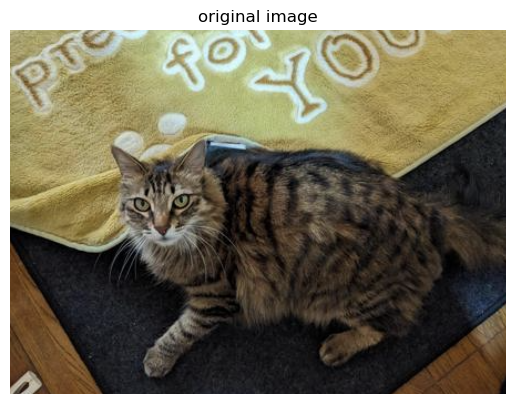

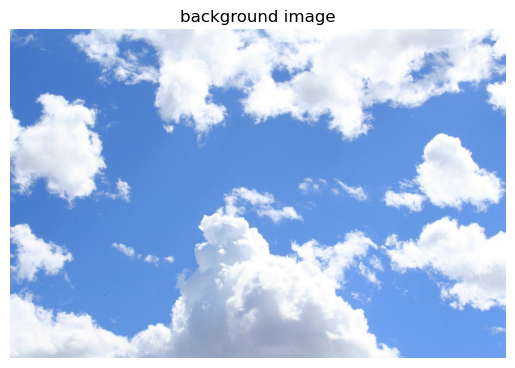

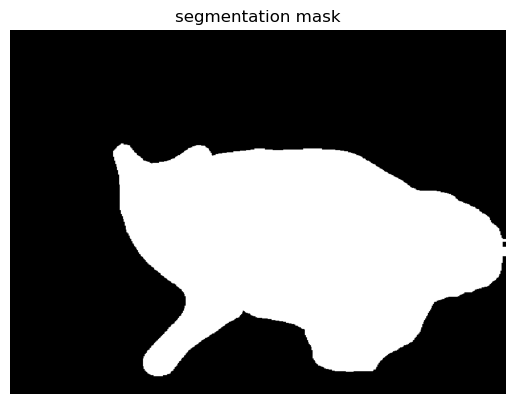

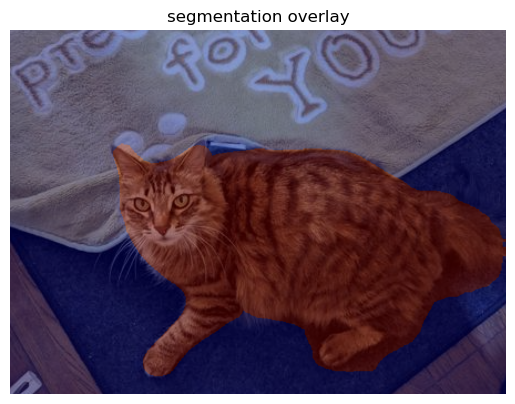

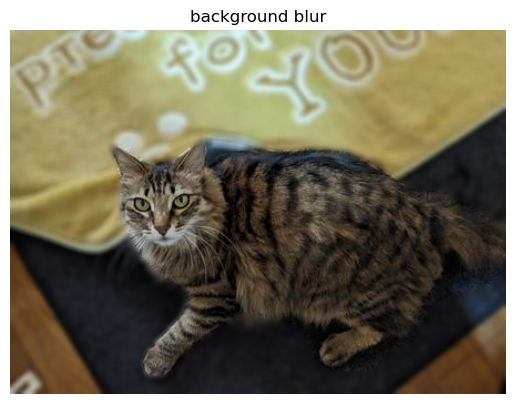

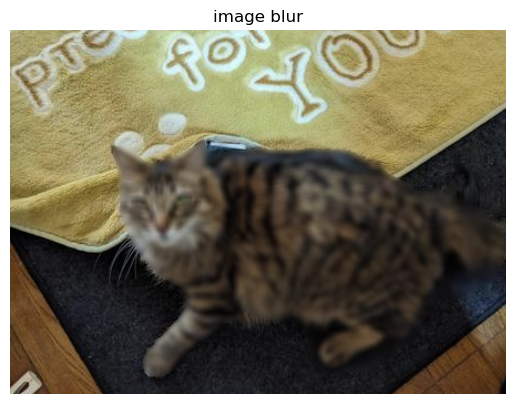

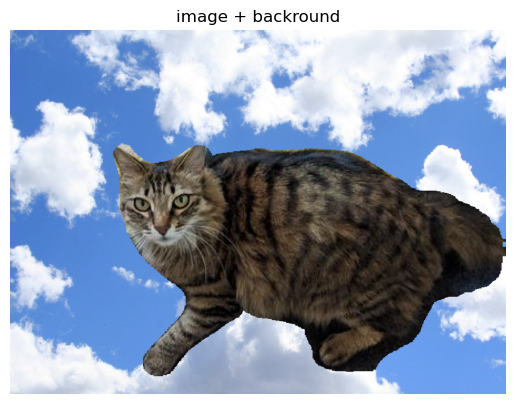

In [3]:
# -------------------------------------------------------------------------------------------------------------------------------
# 필수 라이브러리 
# -------------------------------------------------------------------------------------------------------------------------------
import os
import cv2 # 이미지 처리를 위한 OpenCV 라이브러리
import numpy as np
import torch
from torchvision import transforms # 이미지 전처리를 위한 transforms 라이브러리
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights # DeepLab v3 모델 설치
import matplotlib.pyplot as plt
# -------------------------------------------------------------------------------------------------------------------------------
# 이미지 경로 설정
# -------------------------------------------------------------------------------------------------------------------------------
home_dir = os.getenv('HOME')
# 분할을 원하는 이미지 경로
img_path = os.path.join(home_dir, "work/human_segmentation/images/cat.png")
# 배경으로 사용할 이미지 경로
bg_img_path = os.path.join(home_dir, "work/human_segmentation/images/sky.png")
img_orig = cv2.imread(img_path)
bg_img = cv2.imread(bg_img_path)
# OpenCV는 이미지를 BGR 형식으로 받기 때문에 RGB 형식으로 변환
img_orig_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
bg_img_rgb = cv2.cvtColor(bg_img, cv2.COLOR_BGR2RGB)
print(f"원본 이미지 크기 : {img_orig.shape}")
print(f"배경 이미지 크기 : {bg_img.shape}")
# -------------------------------------------------------------------------------------------------------------------------------
# 이미지 전처리
# -------------------------------------------------------------------------------------------------------------------------------
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize((520, 520)), 
                                transforms.ToTensor(),])
# -------------------------------------------------------------------------------------------------------------------------------
# 이미지 분할을 위한 DeepLab v3 (ResNet-101) 모델 불러오기 
# -------------------------------------------------------------------------------------------------------------------------------
weights = DeepLabV3_ResNet101_Weights.DEFAULT  
model = deeplabv3_resnet101(weights=weights).eval()
# DeepLab v3는 Pascal VOC에 대해 학습되었으며, 아래 클래스들만 분할 가능
# 클래스이름 : 인덱스 번호
# background      : 0     | aeroplane     : 1     | bicycle       : 2
# bird            : 3     | boat          : 4     | bottle        : 5
# bus             : 6     | car           : 7     | cat           : 8
# chair           : 9     | cow           : 10    | diningtable   : 11
# dog             : 12    | horse         : 13    | motorbike     : 14
# person          : 15    | pottedplant   : 16    | sheep         : 17
# sofa            : 18    | train         : 19    | tv            : 20
# 원하는 이미지를 선택할 때 위의 클래스에 속하는 이미지로 선택
# -------------------------------------------------------------------------------------------------------------------------------
# 이미지에 미니 배치 차원 추가
# -------------------------------------------------------------------------------------------------------------------------------
tensor = transform(img_orig_rgb).unsqueeze(0)
# -------------------------------------------------------------------------------------------------------------------------------
# 원하는 이미지 분할을 위한 추론
# -------------------------------------------------------------------------------------------------------------------------------
with torch.no_grad():
    output = model(tensor)["out"][0]
    predictions = output.argmax(0).byte().cpu().numpy()
# -------------------------------------------------------------------------------------------------------------------------------
# 예측된 클래스 레이블을 확인
# -------------------------------------------------------------------------------------------------------------------------------
predictions_class_id = np.unique(predictions)[-1]
print(f"예측된 분할 마스크 크기 : {predictions.shape}")
print(f"예측된 클래스 레이블 : {predictions_class_id}")
# -------------------------------------------------------------------------------------------------------------------------------
# 예측 결과를 원본 이미지의 크기로 변환
# -------------------------------------------------------------------------------------------------------------------------------
# 예측한 분할 마스크 생성을 위한 보간 방법은 최근접 이웃 보간 방법을 사용해야함
# 예측한 분할 마스크는 클래스 인덱스 번호로 구성되어 있기 때문에 가까운 값으로 대체하지 않으면 다른 클래스로 혼동 가능성 있음
predictions_resized = cv2.resize(predictions, (img_orig.shape[1], img_orig.shape[0]), interpolation=cv2.INTER_NEAREST)
bg_img_resized = cv2.resize(bg_img_rgb, (img_orig.shape[1], img_orig.shape[0]))
print(f"원본 이미지 크기로 변환된 예측된 분할 마스크 크기 : {predictions_resized.shape}")
print(f"원본 이미지 크기의 변환된 배경 이미지 크기 : {bg_img_resized.shape}")
# -------------------------------------------------------------------------------------------------------------------------------
# 예측 결과 분할 이미지, 마스크 그리고 배경 처리
# -------------------------------------------------------------------------------------------------------------------------------
# 클래스를 활용해 예측 분할 마스크 생성
seg_map = (predictions_resized == np.unique(predictions)[-1])
# 예측한 분할 마스크를 0(검정색)과 255(흰색)로 구성된 이진 마스크로 변환
img_mask = seg_map.astype(np.uint8) * 255
# 시각화를 위해 0(파란색), 127(녹색) 그리고 255(빨간색)으로 변환해 컬러맵으로 변환
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
print(f"예측된 컬러 마스크 크기 {color_mask.shape}")
# 단일 채널 마스크를 BGR 3채널의 마스크로 변환
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
# 클래스 영역을 제외한 배경만 남는 마스크 생성
img_bg_mask = cv2.bitwise_not(img_mask_color)
# 원본 이미지에 블러 처리 값이 커질수록 블러가 강해짐
img_orig_blur = cv2.blur(img_orig, (13, 13))
# 배경만 남는 마스크에 블러 처리
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
# 클래스 영역은 원본 그리고 클래스 영역을 제외한 부분은 블러 처리
img_bg_blur_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# 클래스 영역을 제외한 부분은 원본 그리고 클래스 영역은 블러 처리
img_orig_blur_concat = np.where(img_mask_color == 255, img_orig_blur, img_orig)
# 클래스 영역은 원본 그리고 클래스 영역을 제외한 부분은 배경 이미지로 대체
img_bg_concat = np.where(img_mask_color == 255, img_orig_rgb, bg_img_resized)
# -------------------------------------------------------------------------------------------------------------------------------
# 시각화
# -------------------------------------------------------------------------------------------------------------------------------
# 원본 이미지 시각화
plt.imshow(img_orig_rgb)
plt.title("original image")
plt.axis('off')
plt.show()
# 배경 이미지 시각화
plt.imshow(bg_img_rgb)
plt.title("background image")
plt.axis('off')
plt.show()
# 예측한 분할 마스크 시각화
plt.imshow(img_mask_color)
plt.title("segmentation mask")
plt.axis('off')
plt.show()
# 예측한 분할 마스크와 배경 시각화
img_bgr = cv2.addWeighted(img_orig, 0.6, color_mask, 0.4, 0.0)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.title("segmentation overlay")
plt.axis('off')
plt.show()
# 원본 이미지의 예측한 분할 마스크에 해당하지 않는 부분 블러 처리 시각화
plt.imshow(cv2.cvtColor(img_bg_blur_concat, cv2.COLOR_BGR2RGB))
plt.title("background blur")
plt.axis('off')
plt.show()
# 원본 이미지의 예측한 분할 마스크에 해당하는 부분 블러 처리 시각화
plt.imshow(cv2.cvtColor(img_orig_blur_concat, cv2.COLOR_BGR2RGB))
plt.title("image blur")
plt.axis('off')
plt.show()
# 원본 이미지의 예측한 분할 마스크에 해당하는 부분과 배경이미지 합성 시각화
plt.imshow(img_bg_concat)
plt.title("image + backround")
plt.axis('off')
plt.show()
# -------------------------------------------------------------------------------------------------------------------------------

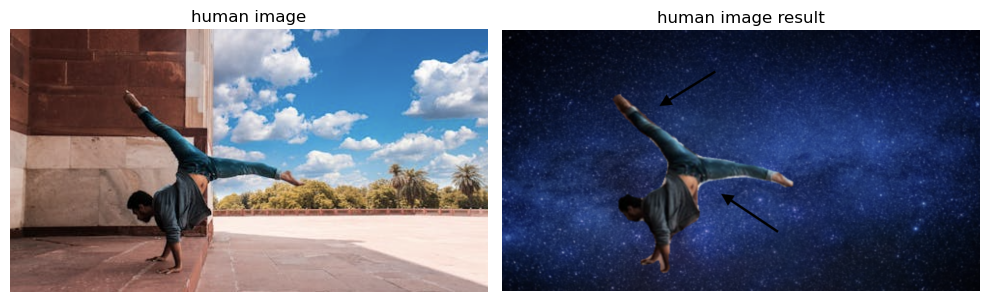

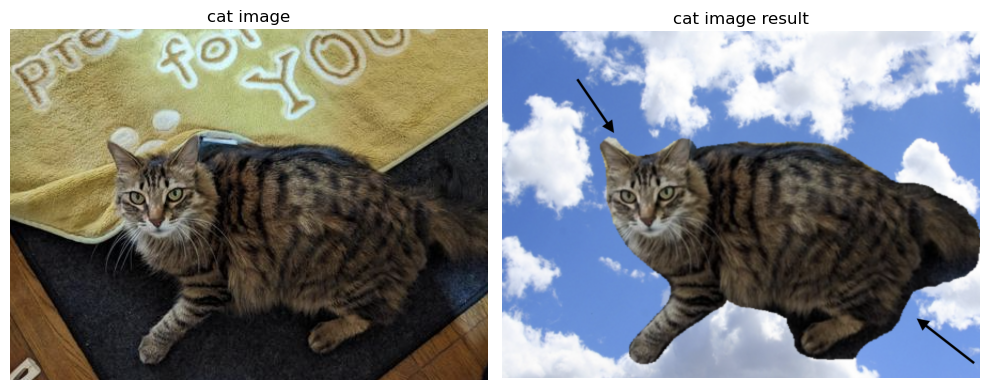

In [4]:
# -------------------------------------------------------------------------------------------------------------------------------
# 프로젝트 결과 시각화
# -------------------------------------------------------------------------------------------------------------------------------
import cv2
import matplotlib.pyplot as plt
# -------------------------------------------------------------------------------------------------------------------------------
home_dir = os.getenv('HOME')
human_img_path = os.path.join(home_dir, "work/human_segmentation/images/human.png")
human_result_img_path = os.path.join(home_dir, "work/human_segmentation/images/human_result.png")
cat_img_path = os.path.join(home_dir, "work/human_segmentation/images/cat.png")
cat_result_img_path = os.path.join(home_dir, "work/human_segmentation/images/cat_result.png")
# -------------------------------------------------------------------------------------------------------------------------------
human_img_orig = cv2.imread(human_img_path)
human_result_img_orig = cv2.imread(human_result_img_path)
cat_img_orig = cv2.imread(cat_img_path)
cat_result_img_orig = cv2.imread(cat_result_img_path)
# -------------------------------------------------------------------------------------------------------------------------------
human_img_orig_rgb = cv2.cvtColor(human_img_orig, cv2.COLOR_BGR2RGB)
human_result_img_orig_rgb = cv2.cvtColor(human_result_img_orig, cv2.COLOR_BGR2RGB)
cat_img_orig_rgb = cv2.cvtColor(cat_img_orig, cv2.COLOR_BGR2RGB)
cat_result_img_orig_rgb = cv2.cvtColor(cat_result_img_orig, cv2.COLOR_BGR2RGB)
# -------------------------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  
plt.imshow(human_img_orig_rgb)
plt.title("human image")
plt.axis('off')
plt.subplot(1, 2, 2)  
plt.imshow(human_result_img_orig_rgb)
plt.title("human image result")
plt.axis('off')
plt.tight_layout()
plt.show()
# -------------------------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  
plt.imshow(cat_img_orig_rgb)
plt.title("cat image")
plt.axis('off')
plt.subplot(1, 2, 2)  
plt.imshow(cat_result_img_orig_rgb)
plt.title("cat image result")
plt.axis('off')
plt.tight_layout()
plt.show()
# -------------------------------------------------------------------------------------------------------------------------------

In [5]:
# -------------------------------------------------------------------------------------------------------------------------------
# Review
# -------------------------------------------------------------------------------------------------------------------------------
# DeepLab v3를 기반으로 춤추는 사람 이미지와 카페트 위에 누워 있는 고양이 이미지에 대해 객체 분할을 수행하였다.
# 전체적으로 클래스 구분은 잘 이루어졌지만, 경계가 매끄럽지 않고 들쭉날쭉하거나 울퉁불퉁한 결과가 나타났으며,
# 분할된 이미지에서는 객체가 일부 잘려 나가거나, 배경과 유사한 색상 영역에서 정확도가 떨어지는 문제가 확인되었다.
# 또한, 객체가 아닌 배경 일부가 포함되는 오탐지도 발생하였다. 이러한 문제들은 사용한 모델 구조와 밀접한 관련이 있다.
# DeepLab v3는 디코더 모듈이 없는 구조이기 때문에 고해상도 정보를 복원하는 과정이 존재하지 않으며,
# 이로 인해 머리카락, 고양이 귀 그리고 얇은 다리와 같은 섬세한 경계는 흐릿하게 처리되고,
# 다운샘플링된 피처맵을 단순히 업샘플링만 하기 때문에 작은 객체가 잘 인식되지 않거나 누락될 가능성이 높다.
# 또한, 저해상도의 피처만 사용하는 구조적 한계로 인해 배경과 색상이 유사한 영역에서 클래스 혼동으로 인한 오탐지도 빈번히 발생한다.
# 이러한 구조적 한계는 디코더 모듈을 포함한 DeepLab v3+ 모델을 사용함으로써 개선할 수 있다.
# DeepLab v3+는 기존 구조에 디코더 모듈을 추가하고, 저수준 피처와 고수준 피처를 결합하여 보다 정밀한 경계 복원이 가능하다.
# 이를 통해 작은 객체나 복잡한 구조를 더 정확하게 분할할 수 있으며, 오탐지 또한 줄일 수 있다.
# 따라서 현재 발생한 대부분의 문제는 DeepLab v3의 구조적 한계에서 기인하며, 
# 이를 해결하기 위해서는 DeepLab v3+와 같은 디코더 기반 모델로의 전환이 효과적인 대안이 될 수 있다.
# 또 다른 해결 방법으로는, 사람이 춤추는 이미지나 고양이가 카페트 위에 누워 있는 이미지처럼
# 실제 사용 환경에 맞춘 도메인 특화 데이터셋을 구성하고 이를 기반으로 사전학습된 모델을 파인튜닝하는 접근 방식이 있다.
# 이렇게 테스크에 잘 맞게 모델을 파인튜닝하면, 해당 상황에 특화된 세밀한 경계 인식과 정확한 객체 분할 성능을 얻을 수 있다.
# 마지막으로, 모델의 구조를 변경하거나 파인튜닝하지 않고도 분할 결과에 후처리 기법을 적용함으로써 성능을 개선할 수 있다.
# 예를 들어, Conditional Random Field나 morphological operation과 같은 후처리를 적용하면 경계가 보다 정교해지고, 
# 작은 잡음이나 오탐지 픽셀을 제거하는 데 도움이 된다.
# 결론적으로, 현재 발생한 문제들을 해결하기 위해서는 디코더 구조가 포함된 DeepLab v3+와 같은 모델로의 변경, 
# 도메인 특화 파인튜닝 그리고 후처리 기법 적용이라는 세 가지 관점을 유기적으로 활용하는 것이 가장 효과적인 접근이 될 수 있다고 생각한다.
# -------------------------------------------------------------------------------------------------------------------------------